In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv("data/SMSSpamCollection", delimiter="\t", header=None)

In [3]:
data.columns = ['class', 'message']

In [4]:
data.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
def spell_corrected(words):
    return words

corpus_stemmed = []
corupus_not_stemmed = []

ps = PorterStemmer()

In [6]:
for i in range(len(data['message'])):
    if i % 500 == 0:
        print(f"Processing message {i}/{len(data)}")

    msg = data['message'][i].lower()

    msg = re.sub(r'[\w\-.]+?@\w+?\.\w{2,4}', ' emailaddr ', msg)
    msg = re.sub(r'(http[s]?\S+)|(\w+\.[a-z]{2,4}\S*)', ' httpaddr ', msg)
    msg = re.sub(r'£|\$', ' moneysymb ', msg)
    msg = re.sub(r'\d+(\.\d+)?', ' number ', msg)
    msg = re.sub(r'\bu\b', ' you ', msg)
    msg = re.sub(r'[^\w\d\s]', ' ', msg)

    msg = msg.split()
    msg = [word for word in spell_corrected(msg) if word is not None]
    corupus_not_stemmed.append(' '.join(msg))

    msg = [ps.stem(word) for word in msg if word not in set(stopwords.words('english'))]
    corpus_stemmed.append(' '.join(msg))

Processing message 0/5572
Processing message 500/5572
Processing message 1000/5572
Processing message 1500/5572
Processing message 2000/5572
Processing message 2500/5572
Processing message 3000/5572
Processing message 3500/5572
Processing message 4000/5572
Processing message 4500/5572
Processing message 5000/5572
Processing message 5500/5572


In [7]:
data['not_stemmed'] = corupus_not_stemmed
data['stemmed'] = corpus_stemmed

In [8]:
data.to_csv("data_cleaned.csv", sep=";", index=False)

In [9]:
data.head()

,class,message,not_stemmed,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif you oni,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in number a wkly comp to win fa cup...,free entri number wkli comp win fa cup final t...
3,ham,U dun say so early hor... U c already then say...,you dun say so early hor you c already then say,dun say earli hor c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,nah think goe usf live around though


In [10]:
data = pd.read_csv("data_cleaned.csv", delimiter=";", index_col=False)

In [11]:
data['stemmed'] = data['stemmed'].fillna("")

In [12]:
data['not_stemmed'] = data['not_stemmed'].fillna("")

In [13]:
data['tokens_stemmed'] = data['stemmed'].apply(lambda x: len(x.split()))
data['characters_stemmed'] = data['stemmed'].apply(len)
data['tokens_not_stemmed'] = data['not_stemmed'].apply(lambda x: len(x.split()))
data['characters_not_stemmed'] = data['not_stemmed'].apply(len)

In [14]:
print(data.columns)

Index(['class', 'message', 'not_stemmed', 'stemmed', 'tokens_stemmed',
       'characters_stemmed', 'tokens_not_stemmed', 'characters_not_stemmed'],
      dtype='object')


In [15]:
print(data['class'].value_counts())

class
ham     4825
spam     747
Name: count, dtype: int64


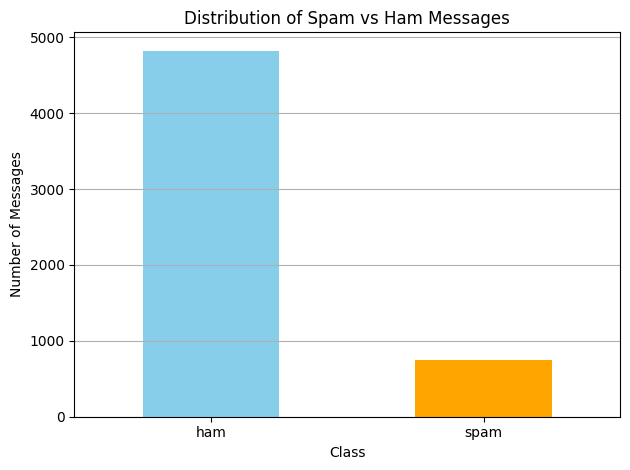

In [16]:
data['class'].value_counts().plot(kind='bar', title='Distribution of Spam vs Ham Messages', color=['skyblue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['stemmed']).toarray()

print("TF-IDF Matrix Shape:", X.shape)


TF-IDF Matrix Shape: (5572, 3000)


In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(data['class'])  # 'ham' → 0, 'spam' → 1


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [20]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
nb = MultinomialNB()
svm = LinearSVC()
logreg = LogisticRegression(max_iter=1000)

In [22]:
nb.fit(X_train, y_train)

MultinomialNB()

In [23]:
svm.fit(X_train, y_train)

LinearSVC()

In [24]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [25]:
from sklearn.metrics import accuracy_score, classification_report

In [26]:
models = {'Naive Bayes': nb, 'SVM': svm, 'Logistic Regression': logreg}

In [27]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n📊 Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


📊 Model: Naive Bayes
Accuracy: 0.9802690582959641
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


📊 Model: SVM
Accuracy: 0.9838565022421525
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.98      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115


📊 Model: Logistic Regression
Accuracy: 0.9721973094170404
              precision    recall  f1-score   support

         Ham       0.97      0.99      0.98       966
        Spam       0.96      0.83      0.89       149

    accuracy                 

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
def plot_confusion(model, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


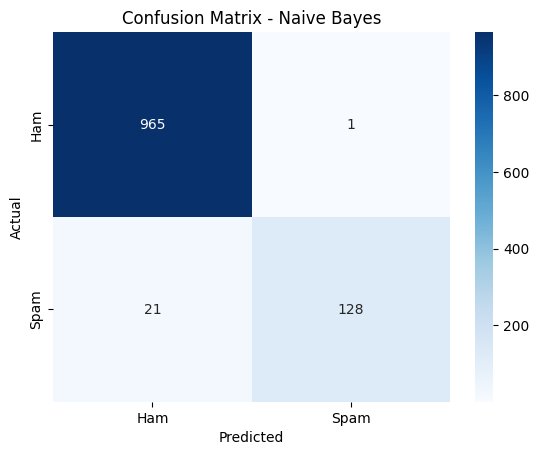

In [30]:
plot_confusion(nb, 'Naive Bayes')

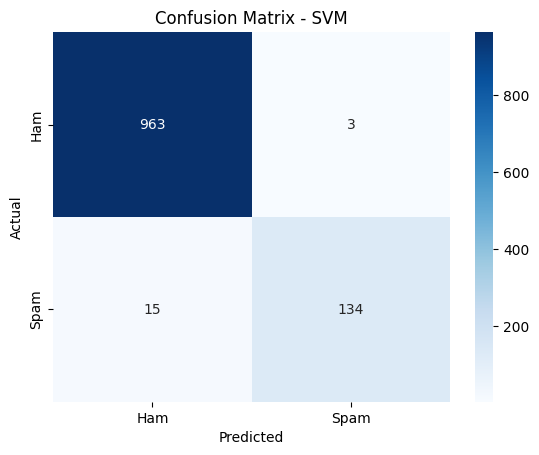

In [31]:
plot_confusion(svm, 'SVM')

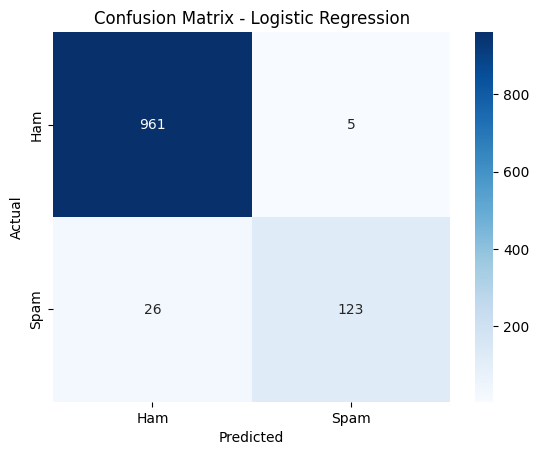

In [32]:
plot_confusion(logreg, 'Logistic Regression')

In [33]:
from wordcloud import WordCloud

spam_words = ' '.join(data[data['class'] == 'spam']['stemmed'])
ham_words = ' '.join(data[data['class'] == 'ham']['stemmed'])

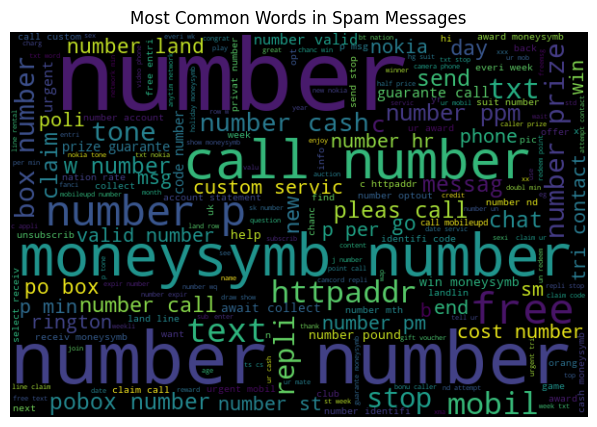

In [34]:
# Spam WordCloud
plt.figure(figsize=(10, 5))
wc = WordCloud(width=600, height=400).generate(spam_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Spam Messages')
plt.show()


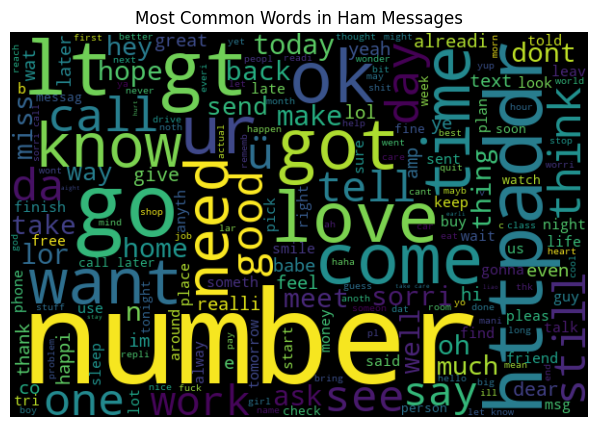

In [35]:
# Ham WordCloud
plt.figure(figsize=(10, 5))
wc = WordCloud(width=600, height=400).generate(ham_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Ham Messages')
plt.show()